# Notebook for texture synthesis for MNIST

In [29]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
])

# Load the MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)


DATASET_IMAGES = 60000
TESTSET_IMAGES = 500
# DataLoader
train_loader = DataLoader(mnist_train, batch_size=DATASET_IMAGES, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=TESTSET_IMAGES, shuffle=False)
 
# Move the data to the specified device (GPU 0)
training_images, training_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))


### Define input args

In [10]:
import datetime
from synthesis_mnist import *

window_size=(28,28)         # Generated image size, (height,width)
kernel_size=7               # history window size
seed_size=7

Synthesis finished. Time used: 10.4s


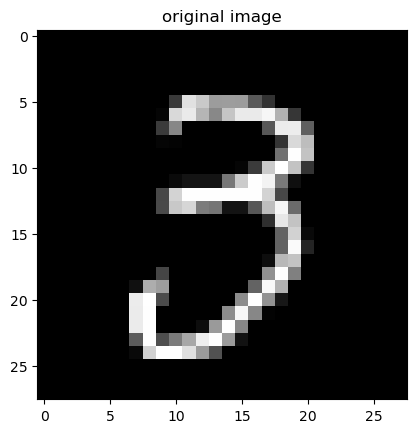

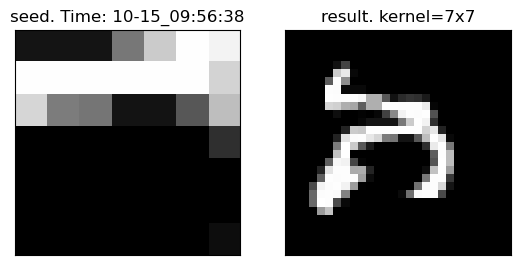

In [12]:
synthesized_texture = synthesize_texture(sample=training_images,
                                         test_sample=test_images,
                                         window_size=window_size, 
                                         kernel_size=kernel_size, 
                                         seed_size=seed_size)

current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%m-%d_%H:%M:%S")  # Format: month-day hour:minute
out_path=f'outputs/mnist/{formatted_time}.png'

fig, [ax1, ax2] = plt.subplots(1,2)
ax2.imshow(synthesized_texture.to('cpu'), vmin=0, vmax=1, cmap='grey')
ax2.set(title=f'result. kernel={kernel_size}x{kernel_size}')
ax2.set_xticks([])
ax2.set_yticks([])

# Place seed in center of window

ph, pw = (window_size[0] - seed_size + 1) // 2, (window_size[1] - seed_size + 1) // 2
original_seed = synthesized_texture[ph:ph+seed_size, pw:pw+seed_size]
ax1.imshow(original_seed.to('cpu'), vmin=0, vmax=1, cmap='grey')
ax1.set(title=f'seed. Time: {formatted_time}')
ax1.set_xticks([])
ax1.set_yticks([])
fig.savefig(out_path)


In [6]:
fig.savefig(out_path)

In [18]:
saved_variables = torch.load('SMT_tensors.pt', map_location=torch.device('cuda:0'))
hop_length = saved_variables['hop_length']
COLOR_NUM = saved_variables['COLOR_NUM']
whiteMat = saved_variables['whiteMat']
basis1 = saved_variables['basis1']
P_star = saved_variables['P_star']
threshold = saved_variables['threshold']
batch_size = saved_variables['batch_size']
PATCH_SIZE = saved_variables['PATCH_SIZE']

/tmp/ipykernel_799517/874041833.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_variables = torch.load('SMT_tensors.pt', map_location=torch.device('cuda:0'))


In [37]:
from einops import rearrange

def unfold_image(imgs,PATCH_SIZE=6,hop_length=2,color_num=3):
    """
    Unfold each image in imgs into a bag of patches.
    Args:
        imgs: Image with dimension [bsz, c, h, w].
        PATCH_SIZE: patch size for each image patch after unfolding, p_h and p_w stands for the height and width of the patch.
    Returns:
        bag_of_patche: List of image patches with size [bsz, c, p_h, p_w, num_patches]. Each patch has the shape [c, p_h, p_w]
    """
    bag_of_patches = F.unfold(imgs, PATCH_SIZE, stride=hop_length)
    bag_of_patches = rearrange(bag_of_patches,"bsz (c p_h p_w) b -> bsz c p_h p_w b",c=color_num,p_h=PATCH_SIZE)
    return bag_of_patches


# essential function to implement SMT
def sparsify_general1(x, basis, t = 0.3):
    """
    This function gives the general sparse feature for image patch x. We calculte the cosine similarity between
    each image patch x and each dictionary element in basis. If the similarity pass threshold t, then the activation
    is 0, else, the actiavtion is 0.

    Assume both x and basis is normalized.

    Args:
        x: Flattened image patches with dimension [bsz, p_w*p_h*c].
        basis: dictionary/codebook with dimension [p_w*p_h*c,num_dict_element], each column of the basis is a dictionary element.
        t: threshold
    Returns:
        bag_of_patche: List of image patches with size [bsz, c, ps, ps, num_patches]. Each patch has the shape [c, ps, ps]
    """

    a = (torch.mm(basis.t(), x) > t).float()
    # plt.imshow(a.cpu())
    # error
    return a



  1%|          | 39/6000 [00:00<00:15, 383.90it/s]

100%|██████████| 6000/6000 [00:16<00:00, 371.97it/s]

torch.Size([60000, 350, 4, 4])


num_test_images 3
num_train_images 59997
training_images torch.Size([60000, 1, 28, 28])


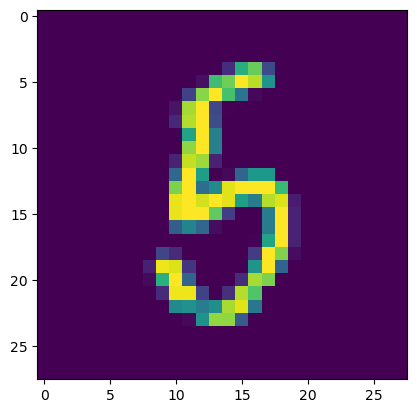

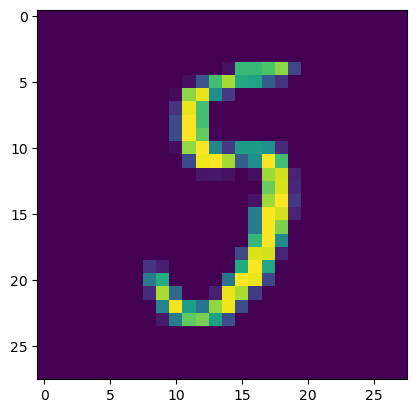

In [56]:
#     unfold each image into a bag of patches
# idx=10
output_w=4
IMAGE_SIZE = 28
num_dim = 350

RG = int((IMAGE_SIZE-PATCH_SIZE)/hop_length)+1

temp_train_1 = torch.zeros([training_images.size(0),num_dim,output_w,output_w])


for idx in tqdm(range(0,training_images.size(0), batch_size)):
# for idx in range(0,training_images.size(0), batch_size):

    patches =unfold_image(training_images[idx:idx+batch_size].to(device),PATCH_SIZE=PATCH_SIZE,hop_length=hop_length,color_num=COLOR_NUM)
    #     demean/center each image patch
    patches = patches.sub(patches.mean((2,3),keepdim =True))
    #     aggregate all patches into together (squeeze into one dimension).
    x = rearrange(patches,"bsz c p_h p_w b  ->bsz (c p_h p_w) b ")
    x_flat = rearrange(x,"bsz p_d hw -> p_d (bsz hw)")
    #     apply whiten transform to each image patch
    x_flat = torch.mm(whiteMat, x_flat)
    #     normalize each image patch
    x_flat = x_flat.div(x_flat.norm(dim = 0, keepdim=True)+1e-9)
    #     extract sparse feature vector ahat from each image patch, sparsify_general1 is f_gq in the paper
    ahat = sparsify_general1(x_flat, basis1, t=threshold)
    # ahat = one_sparse(x_flat, basis1)
    #     project the sparse code into the spectral embeddings
    temp = torch.mm(P_star, ahat)
    temp = temp.div(temp.norm(dim=0, keepdim=True)+ 1e-9)
    temp = rearrange(temp,"c (b2 h w) -> b2 c h w",b2=batch_size,h=RG)
    #     apply spatial pooling
    temp_train_1[idx:idx+batch_size,...] = F.adaptive_avg_pool2d(F.avg_pool2d(temp, kernel_size = 5, stride = 3), output_w)

print(temp_train_1.shape)




def softknn_SMT_filter(test_features,train_features,k=30,T=0.03,max_distance_matrix_size=int(5e6),distance_fx: str = "cosine",epsilon: float = 0.00001):

    if distance_fx == "cosine":
        train_features = F.normalize(train_features)
        test_features = F.normalize(test_features)

    num_train_images = train_features.shape[0]
    num_test_images = test_features.shape[0]
    print('num_test_images',num_test_images)
    print('num_train_images',num_train_images)

    k = min(k, num_train_images)

    # calculate the dot product and compute top-k neighbors
    if distance_fx == "cosine":
        similarities = torch.mm(test_features, train_features.t())
    elif distance_fx == "euclidean":
        similarities = 1 / (torch.cdist(test_features, train_features) + epsilon)
    else:
        raise NotImplementedError

    similarities, train_indices = similarities.topk(k, largest=True, sorted=True)
    # print(train_features.shape)
    # print(similarities.shape)
    # print(indices.shape)

    return train_indices


indices = softknn_SMT_filter(temp_train_1.flatten(1)[0:3],temp_train_1.flatten(1)[3:])

print('training_images',training_images.shape)
test_img_idx = 2
plt.figure()
plt.imshow(training_images[test_img_idx].squeeze())
plt.figure()
plt.imshow(training_images[indices[test_img_idx,0]+3].squeeze())